# ▒ 영화 추천 시스템 ▒


*   문제정의: 사용자 평점 데이터를 기반으로 다양한 추천 알고리즘을 실험하고 가장 효과적인 추천 방식 찾기

*   데이터셋:
      *   출처: MovieLens
      *   ratings.csv: 사용자-영화 간 평점 데이터(약 100,000개)
      *   movies.csv: 영화 ID, 제목, 장르 정보
      *   tags.csv: 사용자가 남긴 영화 관련 태그

*   목표:
      *   사용자 행동(평점, 태그)을 기반으로 개인화된 영화 추천 시스템 구현
      *   협업 필터링, 콘텐츠 기반, 하이브리드 방식 등의 성능 비교 분석
      *   사용자가 아직 보지 않았을 영화 중 선호할 가능성이 높은 작품 추천

## 0. 환경설정

In [1]:
!pip install pandas numpy scikit-learn surprise matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2611316 sha256=4189e0be1c1b115a6d0a2808d59b2b877c9db9120b900eaf1dacf4510444f2ca
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [2]:
pip uninstall numpy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.12/dist-packages/numpy-2.0.2.dist-info/*
    /usr/local/lib/python3.12/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.12/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.12/dist-packages/numpy.libs/libscipy_openblas64_-99b71e71.so
    /usr/local/lib/python3.12/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-2.0.2


In [3]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 56.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import surprise
from surprise import Dataset, Reader, SVD, SVDpp, BaselineOnly, KNNBasic, KNNWithMeans, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy
from surprise.model_selection import cross_validate

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## 1. 데이터 불러오기

In [2]:
ratings = pd.read_csv("/content/drive/MyDrive/data/ratings.csv")
movies = pd.read_csv("/content/drive/MyDrive/data/movies.csv")
tags   = pd.read_csv("/content/drive/MyDrive/data/tags.csv")

print("Ratings:", ratings.shape)
print("Movies:", movies.shape)
print("Tags:", tags.shape)

Ratings: (100836, 4)
Movies: (9742, 3)
Tags: (3683, 4)


* 영화 수에 비해 평점 수가 충분히 많으므로 협업 필터링 가능
* 태그 수는 적지만 콘텐츠 기반 추천의 다양성을 높이는데 기여 가능

## 2. 데이터 살펴보기(EDA)

In [3]:
# 평점 데이터
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


* 평점 데이터는 사용자와 영화의 연결고리 역할
* timestamp를 이용하여 "시간대별 선호도 변화" 분석도 가능

In [4]:
# 영화 데이터
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


* 장르 기반 추천 활용 가능

In [5]:
# 태그 데이터
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


* 태그는 사용자의 주관적인 감상 표현으로 콘텐츠 기반 필터링에서 영화의 특징 벡터로 활용 가능
* 자연어 전처리(NLP) 기법으로 자주 등장하는 키워드를 뽑아낼 수 있음
* 평점과 달리 감상적인 표현이 많아 추천 품질을 보완하는데 유용

In [6]:
# 기본 통계
print("고유 사용자 수:", ratings['userId'].nunique())
print("고유 영화 수:", ratings['movieId'].nunique())
print("평점 개수:", ratings.shape[0])

고유 사용자 수: 610
고유 영화 수: 9724
평점 개수: 100836


In [7]:
# 평점 데이터 정보 및 결측치
ratings.info()
ratings.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


,0
userId,0
movieId,0
rating,0
timestamp,0


In [8]:
# 영화 데이터 정보 및 결측치
movies.info()
movies.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


,0
movieId,0
title,0
genres,0


In [9]:
# 태그 데이터 정보 및 결측치
tags.info()
tags.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


,0
userId,0
movieId,0
tag,0
timestamp,0


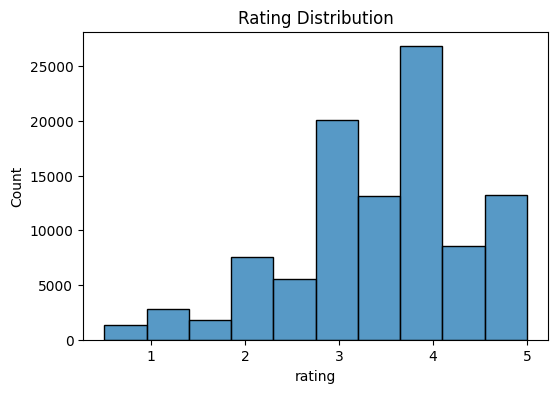

In [10]:
# 평점 분포
plt.figure(figsize=(6,4))
sns.histplot(ratings['rating'], bins=10, kde=False)
plt.title("Rating Distribution")
plt.show()

* 전반적으로 그래프가 오른쪽으로 치우친 형태 -> 사용자가 긍정적인 평점을 주는 경향이 있음
* 가장 많은 평점은 4점 근처 -> 데이터가 점반적으로 낮은평가보다 평균 이상 영화를 중심으로 구성되어 있음
* 이런 치우친 분포는 모델에 편향을 줄 수 있음 -> 이를 완화하기 위해 평점 정규화나 사용자별 평균 평점 차감 등을 추가하는 방법을 고려해볼 수 있음



> 사용자들은 좋은 영화 위주로 평가하므로 "좋아요 기반 추천" 보다 "유사한 취향 사용자 기반" 접근이 효과적일 수 있음

> 즉 협업 필터링 접근이 가장 적합한 데이터 구조로 보임



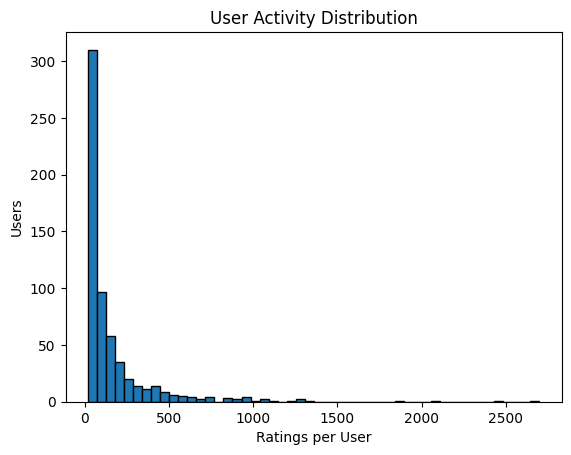

In [11]:
# 유저별 평가 개수
user_counts = ratings['userId'].value_counts()
plt.hist(user_counts, bins=50, edgecolor="black")
plt.xlabel("Ratings per User")
plt.ylabel("Users")
plt.title("User Activity Distribution")
plt.show()

* 대부분의 유저가 적은 수의 영화만 평가함
* 일부 극소수의 유저는 수백~수천 개의 평가를 남김 -> 데이터가 극도로 불균형함

>  성능저하를 막기 위해 평가 수가 너무 적은 사용자는 제거하는 방식을 고려해볼 수 있음 -> 데이터 전처리 단계에서 활성 사용자만을 추려내 모델의 안정성과 정확도를 높일 수 있음

In [12]:
# 영화별 평균 평점 & 평가 수
movie_stats = ratings.groupby('movieId').agg({'rating':['mean','count']})
movie_stats.columns = ['avg_rating','num_ratings']
movie_stats = movie_stats.reset_index()

# 인기 영화 Top-10
top_movies = movie_stats.sort_values(['avg_rating','num_ratings'], ascending=False).head(10)
top_movies = top_movies.merge(movies[['movieId','title']], on='movieId')
top_movies[['title','avg_rating','num_ratings']]

,title,avg_rating,num_ratings
0,Lamerica (1994),5.0,2
1,Heidi Fleiss: Hollywood Madam (1995),5.0,2
2,Lesson Faust (1994),5.0,2
3,Jonah Who Will Be 25 in the Year 2000 (Jonas q...,5.0,2
4,Belle époque (1992),5.0,2
5,Come and See (Idi i smotri) (1985),5.0,2
6,Enter the Void (2009),5.0,2
7,"Awfully Big Adventure, An (1995)",5.0,1
8,Live Nude Girls (1995),5.0,1
9,In the Realm of the Senses (Ai no corrida) (1976),5.0,1


* 평균 평점이 5.0 이지만 평가 수가 1~2개로 실제 인기 있는 영화라고 판단하기에는 무리가 있음 -> 평가 수가 적으면 왜곡이 있을 수 있음을 보여줌
* 신뢰도 있는 인기 영화를 뽑기 위해선 보정이 필요

In [13]:
# 영화별 평균 평점 & 평가 수
movie_stats = ratings.groupby('movieId').agg({'rating':['mean','count']})
movie_stats.columns = ['avg_rating','num_ratings']
movie_stats = movie_stats.reset_index()

# 인기 영화 Top-10
min_ratings = 50
popular_movies = movie_stats[movie_stats['num_ratings'] >= min_ratings]
top_movies = popular_movies.sort_values('avg_rating', ascending=False).head(10)
top_movies = top_movies.merge(movies[['movieId','title']], on='movieId')
print(top_movies[['title', 'avg_rating', 'num_ratings']])

                                               title  avg_rating  num_ratings
0                   Shawshank Redemption, The (1994)    4.429022          317
1                              Godfather, The (1972)    4.289062          192
2                                  Fight Club (1999)    4.272936          218
3                              Cool Hand Luke (1967)    4.271930           57
4  Dr. Strangelove or: How I Learned to Stop Worr...    4.268041           97
5                                 Rear Window (1954)    4.261905           84
6                     Godfather: Part II, The (1974)    4.259690          129
7                               Departed, The (2006)    4.252336          107
8                                  Goodfellas (1990)    4.250000          126
9                                  Casablanca (1942)    4.240000          100


* 일정 수준 이상으로 평가된 영화 중에서 평점이 높은 영화 순위를 볼 수 있음
* 다만 평가 수가 많은 영화의 신뢰도가 충분히 반영되지 못함

In [14]:
# 가중 평균 반영 인기 영화
C = movie_stats['avg_rating'].mean()   # 전체 평균 평점
m = 50

def weighted_rating(x, m=m, C=C):
    v = x['num_ratings']
    R = x['avg_rating']
    return (v/(v+m) * R) + (m/(v+m) * C)

movie_stats['weighted_rating'] = movie_stats.apply(weighted_rating, axis=1)
top_movies = movie_stats.sort_values('weighted_rating', ascending=False).head(10)
top_movies = top_movies.merge(movies[['movieId','title']], on='movieId')

print(top_movies[['title', 'avg_rating', 'num_ratings', 'weighted_rating']])

                                               title  avg_rating  num_ratings  \
0                   Shawshank Redemption, The (1994)    4.429022          317   
1                                  Fight Club (1999)    4.272936          218   
2                              Godfather, The (1972)    4.289062          192   
3          Star Wars: Episode IV - A New Hope (1977)    4.231076          251   
4                                Pulp Fiction (1994)    4.197068          307   
5                                 Matrix, The (1999)    4.192446          278   
6                            Schindler's List (1993)    4.225000          220   
7                         Usual Suspects, The (1995)    4.237745          204   
8                                Forrest Gump (1994)    4.164134          329   
9  Star Wars: Episode V - The Empire Strikes Back...    4.215640          211   

   weighted_rating  
0         4.270088  
1         4.084412  
2         4.076952  
3         4.070174  
4  

* 평가 수가 많을수록 신뢰도가 높다는 점을 반영하여 보다 보편적으로 인기 있는 영화를 도출

## 3. 협업 필터링 기반 추천 (ratings.csv 사용)

In [15]:
# timestamp → datetime 변환
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Surprise Dataset 준비
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=123)

results = []
results_cv = {}

In [16]:
# 평가 함수 정의 (Precision@K, Recall@K)

from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=4.0):
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = {}, {}
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]

        n_rel = sum(true_r >= threshold for (_, true_r) in user_ratings)
        n_rec_k = sum(est >= threshold for (est, _) in top_k)
        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold)
                              for (est, true_r) in top_k)

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return np.mean(list(precisions.values())), np.mean(list(recalls.values()))

### 3.1. SVD (Baseline)

In [17]:
svd = SVD(random_state=123)
svd.fit(trainset)

# 평가
preds = svd.test(testset)
rmse = accuracy.rmse(preds)
mae = accuracy.mae(preds)
precision, recall = precision_recall_at_k(preds, k=10)
results.append(["SVD", rmse, mae, precision, recall])
results_cv["SVD (Baseline)"] = cross_validate(SVD(random_state=123), data, measures=['RMSE','MAE'], cv=5, verbose=True)

RMSE: 0.8749
MAE:  0.6708
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8780  0.8765  0.8674  0.8783  0.8682  0.8737  0.0049  
MAE (testset)     0.6756  0.6703  0.6680  0.6760  0.6670  0.6714  0.0038  
Fit time          1.41    1.42    1.44    1.41    1.46    1.43    0.02    
Test time         0.26    0.12    0.26    0.11    0.11    0.17    0.07    


* SVD는 협업 필터링의 기본 모델로 사용자-아이템 간 패턴을 잘 학습함
* MAE는 0.6708, RMSE는 약 0.87로 모델이 대부분의 평점은 잘 맞추지만 일부 영화에 대해 큰 오차가 존재 -> 일부 사용자나 특정 영화가 다른 패턴을 보이는 것으로 해석 가능
* 교차 검증 결과 표준편차가 작음 -> 데이터 샘플링에 크게 흔들리지 않는 안정적인 모형

### 3.2. GridSearch (SVD 튜닝)

In [18]:
def SVD_with_seed(**kwargs):
  return SVD(random_state=123, **kwargs)

param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.05]
}

gs = GridSearchCV(SVD_with_seed, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
best_svd = gs.best_estimator['rmse']
best_svd.fit(trainset)
preds = best_svd.test(testset)
rmse = accuracy.rmse(preds)
mae = accuracy.mae(preds)
precision, recall = precision_recall_at_k(preds, k=10)
results.append(["SVD (Tuned)", rmse, mae, precision, recall])
results_cv["SVD (tuned)"] = cross_validate(best_svd, data, measures=['RMSE','MAE'], cv=5, verbose=True)

RMSE: 0.8635
MAE:  0.6615
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8490  0.8618  0.8689  0.8667  0.8681  0.8629  0.0074  
MAE (testset)     0.6535  0.6625  0.6636  0.6666  0.6643  0.6621  0.0045  
Fit time          4.37    1.47    1.46    1.45    1.47    2.05    1.16    
Test time         0.15    0.11    0.11    0.26    0.11    0.15    0.06    


* 하이퍼파라미터 조정으로 모델 성능 개선 (RMSE 값이 0.8749에서 0.8352로, MAE 값이 0.6708에서 0.6615로 소폭 개선) -> 모델이 1~2% 정도 더 정확한 예측을 하게됨
* 표준편차가 0.007 수준으로 모델 안정성 확보

### 3.3. BaselineOnly

In [19]:
bsl = BaselineOnly()
bsl.fit(trainset)
preds = bsl.test(testset)
rmse = accuracy.rmse(preds)
mae = accuracy.mae(preds)
precision, recall = precision_recall_at_k(preds, k=10)
results.append(["BaselineOnly", rmse, mae, precision, recall])
results_cv["BaselineOnly"] = cross_validate(BaselineOnly(), data, measures=['RMSE','MAE'], cv=5, verbose=True)

Estimating biases using als...
RMSE: 0.8725
MAE:  0.6712
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8810  0.8700  0.8714  0.8709  0.8685  0.8723  0.0044  
MAE (testset)     0.6788  0.6713  0.6727  0.6711  0.6688  0.6726  0.0033  
Fit time          0.35    0.36    0.42    0.45    0.46    0.41    0.05    
Test time         0.07    0.06    0.34    0.12    0.31    0.18    0.12    


* BaselineOnly는 사용자와 아이템의 평균 평점을 고려해 예측하는 가장 단순한 협업 필터링 모델로 개인화보다는 전체 경향을 반영
* RMSE 값이 0.8725, MAE 값이 0.6712로 단순한 모델이지만 의외로 괜찮은 성능
* 복잡한 모델 대비 효율적(성능 대비 우수한 속도)

### 3.4. KNNBasic

In [20]:
sim_options = {'name': 'cosine', 'user_based': False}
knn = KNNBasic(sim_options=sim_options)
knn.fit(trainset)
preds = knn.test(testset)
rmse = accuracy.rmse(preds)
mae = accuracy.mae(preds)
precision, recall = precision_recall_at_k(preds, k=10)
results.append(["KNNBasic", rmse, mae, precision, recall])
results_cv["KNNBasic"] = cross_validate(KNNBasic(sim_options=sim_options), data, measures=['RMSE','MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9757
MAE:  0.7601
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9797  0.9676  0.9763  0.9861  0.9792  0.9778  0.0060  
MAE (testset)     0.7661  0.7525  0.7590  0.7662  0.7634  0.7615  0.0052  
Fit time          8.01    7.27    7.61    7.54    8.40    7.77    0.39    
Test time         9.97    7.87    6.96    7.14    9.32    8.25    1.20    


* RMSE 값이 0.9757, MAE 값이 0.7601로 Baseline보다 성능이 떨어짐 -> 단순 유사도 기반이 데이터의 희소성에 취약
* 비슷한 영화끼리 추천은 가능하지만 정확한 평점 예측력은 낮음
* 시간이 오래 걸림

### 3.5. KNNWithMeans

In [21]:
knn_means = KNNWithMeans(sim_options=sim_options)
knn_means.fit(trainset)
preds = knn_means.test(testset)
rmse = accuracy.rmse(preds)
mae = accuracy.mae(preds)
precision, recall = precision_recall_at_k(preds, k=10)
results.append(["KNNWithMeans", rmse, mae, precision, recall])
results_cv["KNNWithMeans"] = cross_validate(KNNWithMeans(sim_options=sim_options), data, measures=['RMSE','MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8980
MAE:  0.6875
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9079  0.9091  0.9070  0.8947  0.9073  0.9052  0.0053  
MAE (testset)     0.6920  0.6948  0.6931  0.6848  0.6938  0.6917  0.0036  
Fit time          10.27   7.97    7.04    7.10    7.68    8.01    1.18    
Test time         7.64    8.67    8.69    8.77    7.53    8.26    0.55    


* KNNBasic과 유사하지만 각 사용자 평점에서 개인 평균을 보정하여 예측
* KNNBasic보다 RMSE/MAE 모두 개선됨 -> 평균 보정 효과 확인
* 그러나 여전히 SVD 류보다는 예측 정확도가 낮음
* 유사도 기반 모델의 한계 존재

### 3.6. SVD++

In [22]:
svdpp = SVDpp(random_state=123)
svdpp.fit(trainset)
preds = svdpp.test(testset)
rmse = accuracy.rmse(preds)
mae = accuracy.mae(preds)
precision, recall = precision_recall_at_k(preds, k=10)
results.append(["SVDpp", rmse, mae, precision, recall])
results_cv["SVDpp"] = cross_validate(SVDpp(random_state=123), data, measures=['RMSE','MAE'], cv=5, verbose=True)

RMSE: 0.8576
MAE:  0.6572
Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8608  0.8636  0.8569  0.8661  0.8666  0.8628  0.0036  
MAE (testset)     0.6588  0.6599  0.6571  0.6662  0.6644  0.6613  0.0035  
Fit time          106.70  98.78   98.95   105.95  97.79   101.63  3.86    
Test time         13.09   13.31   13.41   13.44   13.31   13.31   0.12    


* SVD의 확장 버전으로 implicit feedback을 반영
* 협업 필터링 중에서는 좋은 성능이지만 학습 시간이 김

### 3.7. 데이터 필터링 후 SVD

In [23]:
movie_counts = ratings['movieId'].value_counts()
filtered = ratings[ratings['movieId'].isin(movie_counts[movie_counts>=20].index)]
data_filtered = Dataset.load_from_df(filtered[['userId','movieId','rating']], reader)
trainset, testset = train_test_split(data_filtered, test_size=0.2, random_state=123)
svd_filtered = SVD(random_state=123)
svd_filtered.fit(trainset)
preds = svd_filtered.test(testset)
rmse = accuracy.rmse(preds)
mae = accuracy.mae(preds)
precision, recall = precision_recall_at_k(preds, k=10)
results.append(["Filtered SVD", rmse, mae, precision, recall])
results_cv["Filtered SVD"] = cross_validate(SVD(random_state=123), data, measures=['RMSE','MAE'], cv=5, verbose=True)

RMSE: 0.8449
MAE:  0.6483
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8730  0.8774  0.8723  0.8757  0.8703  0.8737  0.0025  
MAE (testset)     0.6711  0.6745  0.6696  0.6744  0.6696  0.6718  0.0022  
Fit time          1.44    1.56    1.50    1.54    1.92    1.59    0.17    
Test time         0.12    0.12    0.11    0.29    0.19    0.17    0.07    


* 퍙가 수가 적은 영화(20개 미만)를 제거한 후 SVD 적용 -> 노이즈를 줄이는 방법
* RMSE 값이 0.8449, MAE 값이 0.6483로 성능이 향상됨
* 데이터 품질 개선이 모델 정확도 향상으로 이어짐
* 적은 평점을 가진 영화 제거가 효과적임을 보여줌



> 평점이 없는 새 영화는 추천 불가능

> 영화의 장르, 태그, 키워드 등 콘텐츠 자체 특징을 분석하여 유사한 영화를 추천하는 콘텐츠 기반 추천 방식을 활용할 수 있음



### 3.8. 모델 성능 비교

In [24]:
df_results = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "Precision", "Recall"])
print(df_results)

          Model      RMSE       MAE  Precision    Recall
0           SVD  0.874852  0.670823   0.588078  0.296020
1   SVD (Tuned)  0.863534  0.661495   0.589955  0.301709
2  BaselineOnly  0.872498  0.671212   0.538985  0.251971
3      KNNBasic  0.975701  0.760140   0.307772  0.210479
4  KNNWithMeans  0.898019  0.687453   0.588502  0.324366
5         SVDpp  0.857589  0.657216   0.588365  0.305060
6  Filtered SVD  0.844860  0.648301   0.599650  0.332698


In [25]:
summary = []

for model_name, cv_result in results_cv.items():
    mean_rmse = cv_result['test_rmse'].mean()
    mean_mae  = cv_result['test_mae'].mean()
    summary.append({
        "Model": model_name,
        "RMSE (mean)": round(mean_rmse, 4),
        "MAE (mean)": round(mean_mae, 4)
    })

df_summary = pd.DataFrame(summary)
print(df_summary)

            Model  RMSE (mean)  MAE (mean)
0  SVD (Baseline)       0.8737      0.6714
1     SVD (tuned)       0.8629      0.6621
2    BaselineOnly       0.8723      0.6726
3        KNNBasic       0.9778      0.7615
4    KNNWithMeans       0.9052      0.6917
5           SVDpp       0.8628      0.6613
6    Filtered SVD       0.8737      0.6718


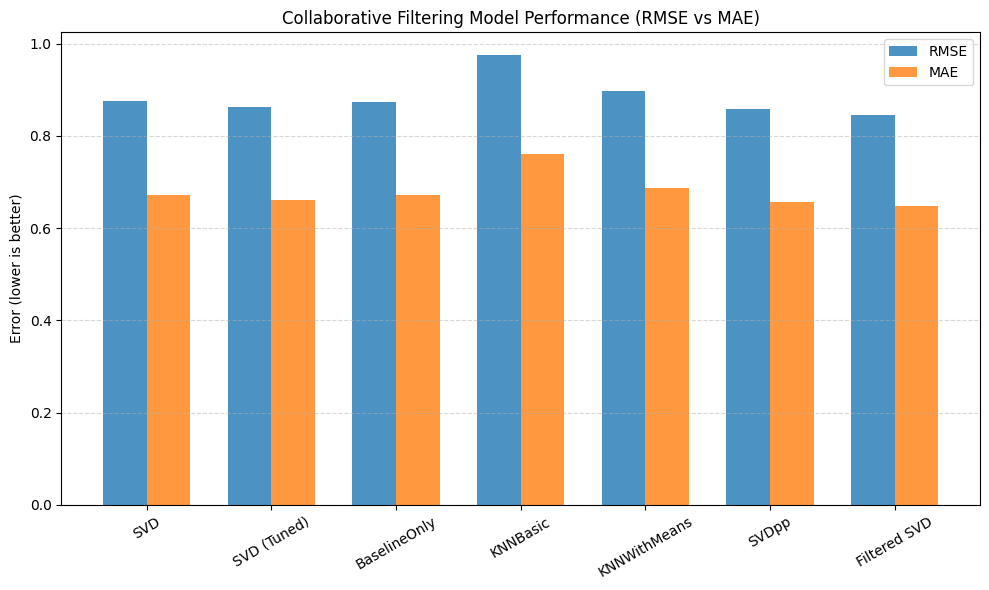

In [26]:
# 데이터 준비
x = np.arange(len(df_results['Model']))
width = 0.35  # 막대 폭

plt.figure(figsize=(10,6))

# RMSE / MAE 나란히 비교
plt.bar(x - width/2, df_results['RMSE'], width, label='RMSE', alpha=0.8)
plt.bar(x + width/2, df_results['MAE'], width, label='MAE', alpha=0.8)

plt.xticks(x, df_results['Model'], rotation=30)
plt.ylabel('Error (lower is better)')
plt.title('Collaborative Filtering Model Performance (RMSE vs MAE)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

* 튜닝된 SVD는 기본 SVD보다 RMSE, MAE 모두 개선됨 -> 하이퍼파라미터 튜닝을 통해 예측 오차를 줄일 수 있음
* BaselineOnly는 평균적인 평점 추정만으로도 꽤 준수한 성능
* KNNBasic vs KNNWithMenas: KNNWithMeans가 RMSE, MAE 모두에서 개선됨 -> 사용자 평균 평점을 고려하는 것이 예측 정확도 향상에 도움
* Filtered SVD가 전체 중 가장 낮은 RMSE와 MAE를 기록 -> 평점 수가 적은 데이터 제거로 노이즈가 줄고 모델 안정성이 향상됨


> 전체적으로 RMSE와 MAE는 모두 유사한 추세

> 데이터 전처리와 하이퍼파라미터 조정이 모델 성능 향상에 핵심적인 요소라는 것을 확인



### 3.9. 가장 성능이 좋았던 모델로 특정 사용자에게 영화 추천

In [27]:
# Filtered SVD
def recommend_movies(user_id, n_recommendations=10):
    # 해당 사용자가 이미 본 영화 제외
    user_rated = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    all_movies = movies['movieId'].tolist()
    unseen_movies = [m for m in all_movies if m not in user_rated]

    # 예측 평점 계산
    predictions = [svd_filtered.predict(user_id, mid) for mid in unseen_movies]
    predictions.sort(key=lambda x: x.est, reverse=True)  # 높은 평점 순으로 정렬

    # 추천 결과 반환
    top_movies = predictions[:n_recommendations]
    recommended_titles = [
        movies[movies['movieId'] == pred.iid]['title'].values[0] for pred in top_movies
    ]
    return recommended_titles

# 예시 실행 (예: userId = 10)
recommendations = recommend_movies(user_id=10, n_recommendations=10)
print("추천 영화 목록:")
for i, title in enumerate(recommendations, start=1):
    print(f"{i}. {title}")


추천 영화 목록:
1. Jurassic Park (1993)
2. Star Wars: Episode V - The Empire Strikes Back (1980)
3. Lawrence of Arabia (1962)
4. On the Waterfront (1954)
5. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
6. Amadeus (1984)
7. Unforgiven (1992)
8. 12 Angry Men (1957)
9. Great Escape, The (1963)
10. Lives of Others, The (Das leben der Anderen) (2006)


## 4. 콘텐츠 기반 추천(TF-IDF + 코사인 유사도)
* movies, tags 활용

In [28]:
# 태그 전처리 (소문자 & 공백 처리)
tags['tag'] = tags['tag'].astype(str).str.lower().str.strip()

# 영화별 태그 결합
movie_tags = tags.groupby('movieId')['tag'].apply(lambda x: " ".join(x)).reset_index()
movies = movies.merge(movie_tags, on="movieId", how="left")

# 장르 + 태그 → content 컬럼 생성
movies['content'] = movies['genres'].fillna('') + " " + movies['tag'].fillna('')

In [29]:
# TF-IDF 벡터화
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movies['content'])

# 코사인 유사도 계산
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 영화 제목으로 유사한 영화 추천 함수
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def recommend_content(title, cosine_sim=cosine_sim, top_n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices].values

print(recommend_content("Toy Story (1995)"))

["Bug's Life, A (1998)" 'Toy Story 2 (1999)'
 'Guardians of the Galaxy 2 (2017)' 'Antz (1998)'
 'Adventures of Rocky and Bullwinkle, The (2000)'
 "Emperor's New Groove, The (2000)" 'Monsters, Inc. (2001)'
 'Wild, The (2006)' 'Shrek the Third (2007)'
 'Tale of Despereaux, The (2008)']


* Toy Stoty(1995)를 기준으로 추천된 영화를 보면 대부분 애니메이션, 가족 도는 모험 장르에 해당하는 영화로 TF-IDF + 코사인 유사도 방식이 장르적 유사성과 서사적 특징을 잘 반영하고 있음을 보여줌
* 유사 장르, 키워드, 내용을 중심으로 추천 -> 협업 필터링의 한계를 보완
* RMSE나 MAE로 비교 불가
* 하지만 새롭거나 다른 장르의 영화를 추천할 수 없음
* 하이브리드 모델로 확장할때 기반 요소로 활용 가능

In [30]:
from sklearn.metrics import precision_score, recall_score

# 한 명 평가 함수
from sklearn.metrics import precision_score, recall_score
import numpy as np
import pandas as pd

def evaluate_content_based(user_id, top_n=10):
    user_ratings = ratings[ratings['userId'] == user_id]
    liked_movies = user_ratings[user_ratings['rating'] >= 4]['movieId'].values
    if len(liked_movies) == 0:
        return None

    last_movie_id = liked_movies[-1]
    last_title = movies[movies['movieId'] == last_movie_id]['title'].values[0]
    recommended = recommend_content(last_title, top_n=top_n)
    recommended_ids = movies[movies['title'].isin(recommended)]['movieId'].values

    y_true = [1 if mid in liked_movies else 0 for mid in recommended_ids]
    y_pred = [1] * len(recommended_ids)

    if sum(y_true) == 0:
        return 0, 0
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return precision, recall

# 여러 사용자 평균 평가 함수
def evaluate_all_users(n_users=100, top_n=10):
    user_ids = ratings['userId'].unique()
    np.random.seed(123)
    sampled_users = np.random.choice(user_ids, size=n_users, replace=False)

    precisions, recalls = [], []

    for uid in sampled_users:
        result = evaluate_content_based(uid, top_n=top_n)
        if result is not None:
            p, r = result
            precisions.append(p)
            recalls.append(r)

    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0

    return avg_precision, avg_recall

# 실행 (결과 출력)
avg_p, avg_r = evaluate_all_users(n_users=100, top_n=10)
print(f"콘텐츠 기반 추천 평균 Precision: {avg_p:.4f}, 평균 Recall: {avg_r:.4f}")

콘텐츠 기반 추천 평균 Precision: 0.0465, 평균 Recall: 0.4040


* 콘텐츠 기반 추천 모델은 사용자 선호 영화와 유사한 콘텐츠를 광법위하게 찾아주는 강점 -> Recall은 높지만 Precision은 낮은경향
* 이는 모델이 정확한 한정된 추천보다 다양한 가능성 있는 후보 탐색에 더 적합하다는 것을 의미
* 추후 임베딩 기반 표현 학습이나 사용자 맞춤형 가중치 적용을 통해 Precision을 높이면 추천 품질을 더욱 균형있게 개선할 가능성이 있음

In [49]:
# 모델 성능 비교

content_based_row = {
    'Model': 'Content-Based (TF-IDF)',
    'RMSE': None,
    'MAE': None,
    'Precision': avg_p,
    'Recall': avg_r
}

# df_results에 행 추가
df_results = pd.concat([df_results, pd.DataFrame([content_based_row])], ignore_index=True)

# 출력
print(df_results)

                    Model      RMSE       MAE  Precision    Recall
0                     SVD  0.874852  0.670823   0.588078  0.296020
1             SVD (Tuned)  0.863534  0.661495   0.589955  0.301709
2            BaselineOnly  0.872498  0.671212   0.538985  0.251971
3                KNNBasic  0.975701  0.760140   0.307772  0.210479
4            KNNWithMeans  0.898019  0.687453   0.588502  0.324366
5                   SVDpp  0.857589  0.657216   0.588365  0.305060
6            Filtered SVD  0.844860  0.648301   0.599650  0.332698
7  Content-Based (TF-IDF)       NaN       NaN   0.046465  0.404040


/tmp/ipython-input-3179135113.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([content_based_row])], ignore_index=True)


* 전반적으로 협업 필터링 기반 모델의 Precision이 높음 -> 협업 필터링은 사용자 간 선호 패턴 유사도를 기반으로 정확한 추천을 하기 때문
* 반면에 Recall은 콘텐츠 기반 모델이 높음 -> 콘텐츠 기반 추천은 유사도를 기반으로 하기 때문에 넓은 범위의 추천이 이루어지기 때문

* RMSE, MAE 측면에서는 Filtered SVD가 가장 좋은 성능
* Precision, Recall 측면에서는 KNNWithMeans와 Filtered SVD가 전반적으로 균형잡힌 결과를 보여줌 -> 콘텐츠 기반 모젤은 Recall이 가장 높지만 Precision이 매우 낮아 실제 정확한 추천에는 약함

* 다만 평점처럼 연속형 자료인 경우 이진 분류에서 나온 Precision과 Recall을 가지고 모델의 성능을 비교하는 것은 적절하지 않을 수 있기 때문에 협업과 콘텐츠 기반 모델을 비교하기 위한 보조적인 정보로만 활용

 > Filtered SVD가 가장 우수한 성능

> 콘텐츠 기반 추천은 보조적 역할로 적함

> 협업 + 콘텐츠 하이브리드 접근의 필요성

##  5. 하이브리드 추천

In [51]:
from sklearn.preprocessing import MinMaxScaler

def hybrid_recommend(user_id, top_n=10, alpha=0.6):
    # 협업 필터링 기반 예측 점수 계산
    all_movies = movies['movieId'].tolist()
    cf_preds = {mid: svd_filtered.predict(user_id, mid).est for mid in all_movies}

    # 사용자 평가 이력 확인
    user_ratings = ratings[ratings['userId'] == user_id]
    if user_ratings.empty:
        print("해당 사용자는 평가 이력이 없습니다.")
        return pd.DataFrame(columns=['movieId', 'title', 'hybrid_score_norm'])

    # 사용자가 최근 본 영화 기준 콘텐츠 유사도 계산
    last_movie_id = user_ratings.sort_values('timestamp', ascending=False).iloc[0]['movieId']
    last_title = movies[movies['movieId'] == last_movie_id]['title'].values[0]
    idx = indices[last_title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_indices = [i[0] for i in sim_scores]

    # 유사도 기반 영화 목록 생성
    sim_movies = movies.iloc[sim_indices].copy()
    sim_movies['content_score'] = [s[1] for s in sim_scores]
    sim_movies['movieId'] = movies.iloc[sim_indices]['movieId'].values

    # 협업 + 콘텐츠 점수 결합
    sim_movies['cf_score'] = sim_movies['movieId'].apply(lambda x: cf_preds.get(x, 0))
    sim_movies['hybrid_score'] = alpha * sim_movies['cf_score'] + (1 - alpha) * sim_movies['content_score']

    # 점수 정규화
    scaler = MinMaxScaler()
    sim_movies['hybrid_score_norm'] = scaler.fit_transform(sim_movies[['hybrid_score']])

    # 이미 본 영화 제외 및 상위 추천
    seen_movies = user_ratings['movieId'].values
    recommendations = sim_movies[~sim_movies['movieId'].isin(seen_movies)]
    recommendations = recommendations.sort_values('hybrid_score_norm', ascending=False)

    # movieId 포함하여 반환
    return recommendations[['movieId', 'title', 'hybrid_score_norm']].head(top_n)

# user_id 10번에게 영화 10개 추천
hybrid_recommend(10, top_n=10, alpha=0.7)

,movieId,title,hybrid_score_norm
898,1196,Star Wars: Episode V - The Empire Strikes Back...,1.000000
418,480,Jurassic Park (1993),0.982282
1045,1357,Shine (1996),0.957041
906,1204,Lawrence of Arabia (1962),0.937692
6165,44555,"Lives of Others, The (Das leben der Anderen) (...",0.921472
1422,1945,On the Waterfront (1954),0.920106
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,0.916108
926,1225,Amadeus (1984),0.915373
965,1266,Unforgiven (1992),0.911110
905,1203,12 Angry Men (1957),0.896937


* 기존 협업 필터링은 사용자의 평점 패턴만을 반영하기 때문에 비슷한 사용자나 영화가 없으면 추천이 어려움
* 콘텐츠 기반은 영화의 줄거리, 장르 등 아이템의 특성을 이용해서 유사한 영화를 추천하지만 개인의 취향 반영은 약함

> 하이브리드 모델은 두 접근법의 단점을 보완한 형태로 사용자의 선호(협업) + 영화 유사도(콘텐츠)를 함께 고려해 좀 더 균형 잡힌 추천을 수행해 보고자 진행

* 추천된 영화들은 시대나 장르가 다양하지만 전반적으로 평점이 높고 스토리 완성도 중심의 작품들이 선택됨 -> 사용자가 과거에 감성, 서사 중심 영화를 선호했을 가능성이 높다는 점을 시사
* alpha 값 조정을 통해 개인화 추천 강화와 콘텐츠 유사성 강화 사이에서 균형을 맞출 수 있음

> 하이브리드 추천 시스템은 협엄 필터링 기반의 평점 예측과 콘텐츠 기반의 영화 유사도를 결합한 모델로 데이터를 다루는 성격이 다르기 때문에 일반적인 정량 지표로 모델 성능을 평가하는 것은 한계 -> 결과 리스트의 합리성과 해석적 통찰을 중심으로 평가

> 단순 평점 에측 정확도(RMSE, MAE)를 넘어 실제 사용자의 만족도나 추천 신뢰도를 높이는 방식으로 추천 시스템이 발전할 수 있음을 시사

## 6. 시간 정보 활용 (가장 성능이 좋았던 Filtered SVD와 비교)


In [33]:
# timestamp → datetime 변환
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# 시간 가중치 계산 (최근일수록 가중치 ↑)
max_time = ratings['timestamp'].max()
min_time = ratings['timestamp'].min()
ratings['time_weight'] = (ratings['timestamp'] - min_time) / (max_time - min_time)

# 가중 평점 계산 (기존 평점에 시간 가중치 반영)
# 오래된 평점은 0.5배, 최신 평점은 1배 정도 반영
ratings['weighted_rating'] = ratings['rating'] * (0.5 + 0.5 * ratings['time_weight'])

# Surprise용 데이터셋 생성
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'weighted_rating']], reader)

# 학습/테스트 분할
trainset, testset = train_test_split(data, test_size=0.2, random_state=123)

# 모델 학습 (Filtered SVD 구조와 동일)
temporal_svd = SVD(random_state=123)
temporal_svd.fit(trainset)

# 성능 평가
predictions = temporal_svd.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.6841
MAE:  0.5180


In [34]:
# 기존 Filtered SVD 결과 불러오기
filtered_svd_row = df_results.loc[df_results['Model'] == 'Filtered SVD', ['Model', 'RMSE', 'MAE']].iloc[0]

# Temporal SVD 결과를 DataFrame 형태로
temporal_svd_row = {
    'Model': 'Temporal SVD',
    'RMSE': rmse,
    'MAE': mae
}

# 두 개만 비교 테이블로 구성
df_compare = pd.concat([
    pd.DataFrame([filtered_svd_row]),
    pd.DataFrame([temporal_svd_row])
], ignore_index=True)

print("\n Filtered SVD vs Temporal SVD 비교 결과")
print(df_compare)


 Filtered SVD vs Temporal SVD 비교 결과
          Model      RMSE       MAE
0  Filtered SVD  0.844860  0.648301
1  Temporal SVD  0.684135  0.517967


* RMSE와 MAE 모두 Temporal SVD가 낮으므로 전반적으로 Temporal SVD가 더 정확 -> 특히 RMSE가 대략 0.16정도 낮다는건 Temporal SVD가 큰 오차를 훨씬 더 냈다는 것을 의미
* Temporal SVD는 Filtered SVD와 달리 시간적 변화를 반영한 모델로 시간이 지날수록 패턴이 변한다는 사실을 모델이 학습하면서 더 현실적인 예측을 한 것 -> 결과적으로 사용자-아이템 상호작용의 진화를 고려하는 것이 성능향상으로 이어짐